In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_dir = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training'
early_blight_dir = os.path.join(train_dir, 'Early_Blight')
healthy_dir = os.path.join(train_dir, 'Healthy')
late_blight_dir = os.path.join(train_dir, 'Late_Blight')

In [5]:
# Function to read images from a directory
def read_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
# Function to resize images
def resize_images(images, target_size=(299, 299)):  # InceptionV3 input size
    resized_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (assuming BGR input)
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)


In [7]:
# Read images from each class directory
early_blight_images = read_images_from_dir(early_blight_dir)
healthy_images = read_images_from_dir(healthy_dir)
late_blight_images = read_images_from_dir(late_blight_dir)

In [8]:
# Print the number of images in each class
print("Number of Early Blight images:", len(early_blight_images))
print("Number of Healthy images:", len(healthy_images))
print("Number of Late Blight images:", len(late_blight_images))

Number of Early Blight images: 1303
Number of Healthy images: 816
Number of Late Blight images: 1132


In [9]:
# Number of images in each class
classes = ['Early Blight', 'Healthy', 'Late Blight']
counts = [len(early_blight_images), len(healthy_images), len(late_blight_images)]

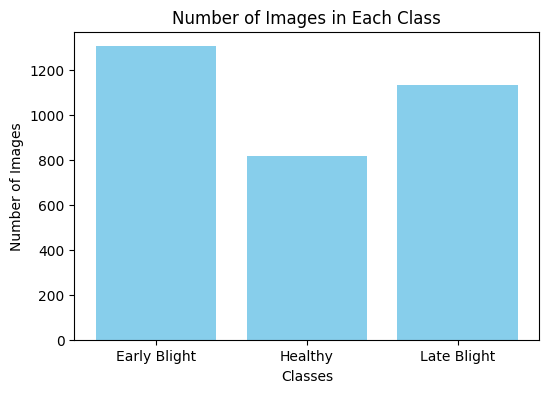

In [10]:
# Create bar graph
plt.figure(figsize=(6, 4))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [11]:
# Resize images for each class
target_size = (299, 299)  # InceptionV3 input size
resized_early_blight = resize_images(early_blight_images, target_size)
resized_healthy = resize_images(healthy_images, target_size)
resized_late_blight = resize_images(late_blight_images, target_size)

In [12]:
# Normalize images for each class
def normalize_images(images):
    return images.astype('float32') / 255.0

# Normalize images
normalized_early_blight = normalize_images(resized_early_blight)
normalized_healthy = normalize_images(resized_healthy)
normalized_late_blight = normalize_images(resized_late_blight)

In [13]:
# Delete unnecessary variables to free up memory
del early_blight_images, healthy_images, late_blight_images
del resized_early_blight, resized_healthy, resized_late_blight

In [14]:
# Concatenate images and labels
X = np.concatenate((normalized_early_blight, normalized_healthy, normalized_late_blight), axis=0)
y = np.array([0]*len(normalized_early_blight) + [1]*len(normalized_healthy) + [2]*len(normalized_late_blight))


In [15]:
# Shuffle X and y in unison
rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
# Load InceptionV3 model pre-trained on ImageNet without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes now

# Combine the base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
# Suppress the specific warning
warnings.filterwarnings("ignore", message="Fallback to op-by-op mode because memset node breaks graph update")

In [23]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
 1/74 ━━━━━━━━━━━━━━━━━━━━ 38:15 31s/step - accuracy: 0.4062 - loss: 1.3286

I0000 00:00:1709582552.776584     150 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709582552.828074     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5609 - loss: 0.9127

W0000 00:00:1709582572.882570     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709582579.756582     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 63s 427ms/step - accuracy: 0.5624 - loss: 0.9102 - val_accuracy: 0.8077 - val_loss: 0.4590
Epoch 2/20


W0000 00:00:1709582584.095508     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.8255 - loss: 0.4595 - val_accuracy: 0.8385 - val_loss: 0.3825
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8421 - loss: 0.3862 - val_accuracy: 0.8692 - val_loss: 0.3112
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.8579 - loss: 0.3599 - val_accuracy: 0.8923 - val_loss: 0.2819
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.8895 - loss: 0.3014 - val_accuracy: 0.9038 - val_loss: 0.2651
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.8889 - loss: 0.2765 - val_accuracy: 0.9000 - val_loss: 0.2577
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9040 - loss: 0.2612 - val_accuracy: 0.8962 - val_loss: 0.2539
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9207 - loss: 0.2377 - val_accuracy: 0.9308 - val_loss: 0.2234
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.9267 - loss: 0.2331 - val_accuracy: 0.9115 - val

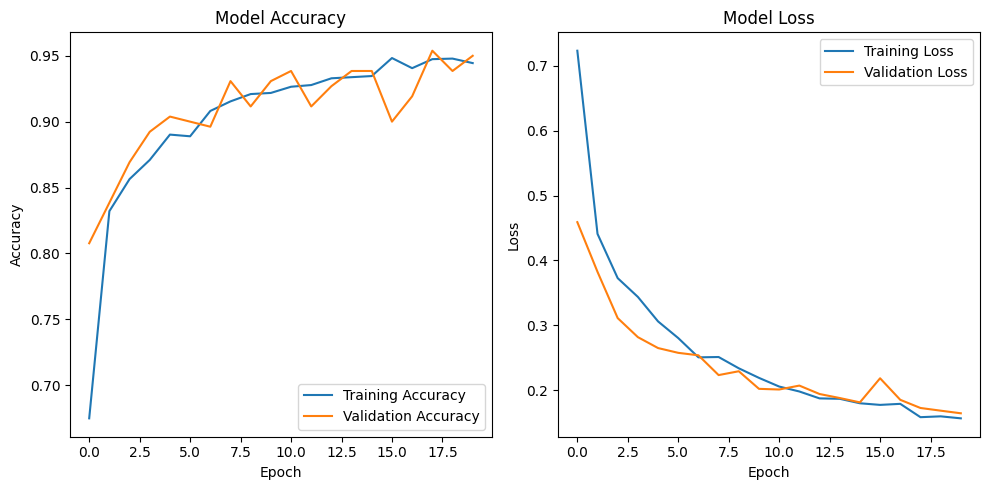

In [24]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate the model on test data
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy:", accuracy)

Accuracy: 0.9231950640678406


W0000 00:00:1709582801.453337     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
# Predict labels
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=-1)

 2/21 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step

W0000 00:00:1709582820.688617     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step


W0000 00:00:1709582828.324971     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9245816643571875
Recall: 0.9231950844854071
F1-score: 0.9236053735895609


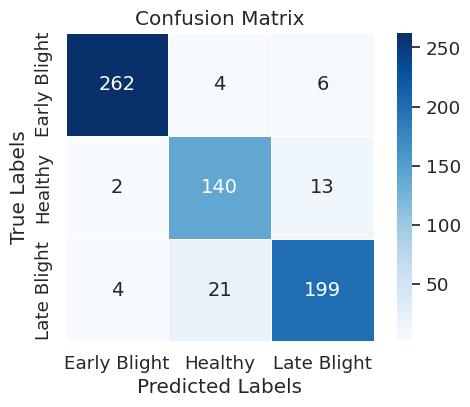

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
#print(cm)

# Labels for the classes
classes = ['Early Blight', 'Healthy', 'Late Blight']

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # for label size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=classes, yticklabels=classes, linewidths=.5, annot_kws={"size": 14})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [35]:
# Define a function to predict the label of an uploaded image
def predict_uploaded_image(model, image_file):
    # Load and preprocess the image
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (299, 299))  # Resize to match model's expected sizing
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img)
    
    # Get the predicted class
    class_idx = np.argmax(predictions)
    
    # Define the class labels
    class_names = {
        0: 'Early Blight',
        1: 'Healthy',
        2: 'Late Blight'
    }
    
    # Get the predicted class label
    predicted_class = class_names[class_idx]
    
    # Get the confidence score
    #confidence = predictions[0][class_idx]

    return predicted_class, confidence

# Path to the image you want to predict
image_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/Late_Blight/Late_Blight_25.jpg'

# Predict the image
predicted_class, confidence = predict_uploaded_image(model, image_path)

# Print the result
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: Late Blight
Confidence: 0.65057456


In [34]:
# Save the model
model.save('Potato-Model.h5')  # Saves the model to a HDF5 file